In [1]:
import h5py
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy import wcs
import lsmtool
import numpy as np

In [37]:
# STEP 1
# Load input/outputs
# SCREEN FITTING INPUTS:
# Load solutions.h5 and skymodel
f = h5py.File('solutions_fullsize.h5', 'r')

# SCREEN FITTING OUTPUTS:
# The screen fitting library produces as output a .fits image cube. 
# The outputs of the two different algorithms are loaded below as 
# "kl_cube" and "voronoi_cube"
# the cube dimensions are = ["time", "freqs", "antennas", "pol", "x_coord", "y_coord"]
kl_cube=fits.open('bigger_screen/kl_0.fits')[0]
voronoi_cube=fits.open('bigger_screen/tessellated_0.fits')[0]

In [38]:
# STEP 2
# Convert the coordinates of the patches in the skymodel to 
# x,y coordinates in the screen
# build image cube with reference points 

# load skymodel
skymod = lsmtool.load("skymodel.txt")
source_dict = skymod.getPatchPositions()
source_positions = []
for source in list(f['sol000/phase000/dir']):
    radecpos = source_dict[str(source, 'utf-8').strip("[]")]
    source_positions.append([radecpos[0].value, radecpos[1].value])
source_positions = np.array(source_positions)

# init wcs object with fits image
filename = 'bigger_screen/kl_0.fits'
hdu = fits.open(filename)
w = wcs.WCS(hdu[0].header)
ra_ind = w.axis_type_names.index("RA")
dec_ind = w.axis_type_names.index("DEC")

# Convert ra-dec to pixel coordinates
RA = source_positions[:,0]
DEC = source_positions[:,1]
xy_coord = []
coord_patch_x =[]
coord_patch_y=[]
for ra_vert, dec_vert in zip(RA, DEC):
    ra_dec = np.array([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]])
    ra_dec[0][ra_ind] = ra_vert
    ra_dec[0][dec_ind] = dec_vert
    xy_coord.append(
        (w.wcs_world2pix(ra_dec, 0)[0][ra_ind], 
         w.wcs_world2pix(ra_dec, 0)[0][dec_ind])
    )
    coord_patch_x.append(int(np.floor(w.wcs_world2pix(ra_dec, 0)[0][dec_ind])))
    coord_patch_y.append(int(np.floor(w.wcs_world2pix(ra_dec, 0)[0][ra_ind])))

print(coord_patch_x)
print(coord_patch_y)

[27, 24, 27, 16, 16, 19, 22]
[14, 24, 27, 28, 15, 18, 21]


In [39]:
# STEP 3
# Select only points inside the screen
# If all patches have coordinates which are inside the screen boundaries, list all
# Otherwise, exclude from patch_idx the patches which fall ouside the screen boundaries
patch_idx = np.array([0,1,2,3,4,5,6])

In [40]:
# STEP 4
# Read amplitude and phase from solution.h5, and subtract reference phase

ampl = f['sol000/amplitude000/val'] # [1, 9, 3, 7, 2]
phase = f['sol000/phase000/val'] # [3, 9, 3 ,7]

ntime = phase.shape[0]
nfreq = phase.shape[1]
nantennas = phase.shape[2]
nsources = phase.shape[3]

phase_corrected = np.zeros((ntime, nfreq, nantennas, nsources))
for i in range(ntime):
    for k in range(nfreq):
        for j in range(nsources):
            phase_corrected[i,k,:,j] = phase[i,k,:,j] - phase[i,k,0,j]

In [41]:
# STEP 5
# Build an image cube containing the input values (from the skymodel)
# at the right xy coordinates, and zeroes elsewhere. 
# A mask is also created which indicates where in the screen the reference points should be placed

# get the number of pixels in the image
im_size = kl_cube.data.shape[4]
npol = 4

grid_kl=np.zeros((ntime, nfreq, nantennas, npol, im_size, im_size))
grid_voronoi=np.zeros((ntime, nfreq, nantennas, npol, im_size, im_size))

patch_mask = np.full((im_size, im_size), False)

for t in range(ntime):
    for i in range(patch_idx.size):
        grid_kl[t, :, :, 0, coord_patch_x[patch_idx[i]], coord_patch_y[patch_idx[i]]] = ampl[0,:,:,patch_idx[i],0] * np.cos(phase_corrected[t,:,:, patch_idx[i]])
        grid_kl[t, :, :, 2, coord_patch_x[patch_idx[i]], coord_patch_y[patch_idx[i]]] = ampl[0,:,:,patch_idx[i],1] * np.cos(phase_corrected[t,:,:, patch_idx[i]])
        grid_kl[t, :, :, 1, coord_patch_x[patch_idx[i]], coord_patch_y[patch_idx[i]]] = ampl[0,:,:,patch_idx[i],0] * np.sin(phase_corrected[t,:,:, patch_idx[i]])
        grid_kl[t, :, :, 3, coord_patch_x[patch_idx[i]], coord_patch_y[patch_idx[i]]] = ampl[0,:,:,patch_idx[i],1] * np.sin(phase_corrected[t,:,:, patch_idx[i]])

        grid_voronoi[t, :, :, 0, coord_patch_x[patch_idx[i]], coord_patch_y[patch_idx[i]]] = np.cos(phase_corrected[t,:,:, patch_idx[i]])
        grid_voronoi[t, :, :, 2, coord_patch_x[patch_idx[i]], coord_patch_y[patch_idx[i]]] = np.cos(phase_corrected[t,:,:, patch_idx[i]])
        grid_voronoi[t, :, :, 1, coord_patch_x[patch_idx[i]], coord_patch_y[patch_idx[i]]] = np.sin(phase_corrected[t,:,:, patch_idx[i]])
        grid_voronoi[t, :, :, 3, coord_patch_x[patch_idx[i]], coord_patch_y[patch_idx[i]]] = np.sin(phase_corrected[t,:,:, patch_idx[i]])
        
        patch_mask[coord_patch_x[patch_idx[i]], coord_patch_y[patch_idx[i]]] = True;


<Figure size 432x288 with 0 Axes>

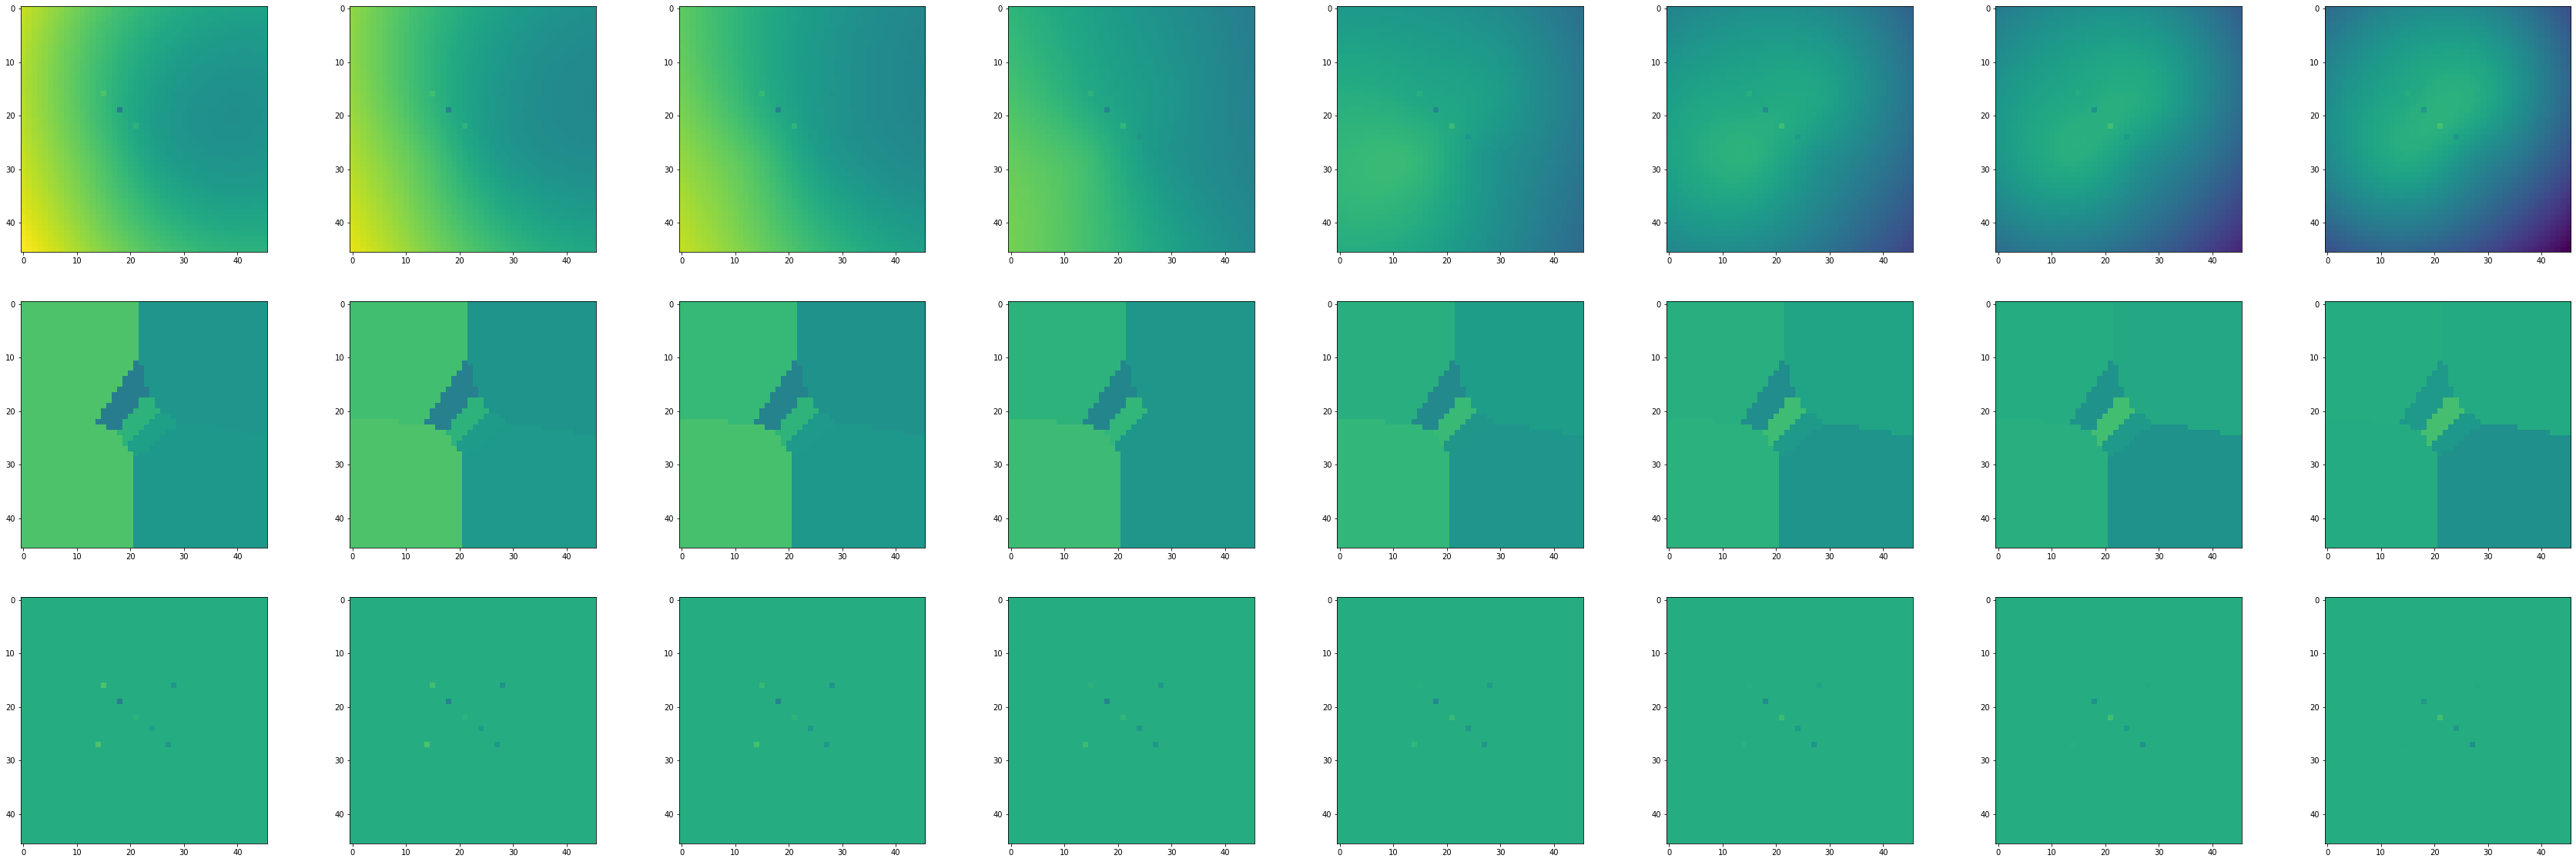

In [42]:
# STEP 3
# Make plots

# Select the indexes to plot
polarization_idx = 1; 
time = 0; # there are 3 time slots
antenna = 1;
freq_offset = 0

n_subplots = 8

kl_min = np.min(kl_cube.data[time,freq_offset:freq_offset+n_subplots,antenna,polarization_idx,:,:])
kl_max = np.max(kl_cube.data[time,freq_offset:freq_offset+n_subplots,antenna,polarization_idx,:,:])
vor_min = np.min(voronoi_cube.data[time,freq_offset:freq_offset+n_subplots,antenna,polarization_idx,:,:])
vor_max = np.max(voronoi_cube.data[time,freq_offset:freq_offset+n_subplots,antenna,polarization_idx,:,:])
grid_min = np.min(grid_kl[time,freq_offset:freq_offset+n_subplots,antenna,polarization_idx,:,:])
grid_max = np.max(grid_kl[time,freq_offset:freq_offset+n_subplots,antenna,polarization_idx,:,:])
colormap_min_val = np.min(np.array([kl_min, vor_min, grid_min]))
colormap_max_val = np.max(np.array([kl_max,vor_max, grid_max]))


plt.figure()
fig, axarr = plt.subplots(3,n_subplots) 
fig.set_size_inches(60, 20)

for i in range(n_subplots):
    kl_screen = kl_cube.data[time,i+freq_offset,antenna,polarization_idx,:,:]
    voronoi_screen = voronoi_cube.data[time,i+freq_offset,antenna,polarization_idx,:,:]
    ref_screen_kl = grid_kl[time,i+freq_offset,antenna,polarization_idx,:,:]
    ref_screen_voronoi = grid_voronoi[time,i+freq_offset,antenna,polarization_idx,:,:]
    
    kl_screen_with_ref = kl_screen* (~patch_mask) + ref_screen_kl * patch_mask
    voronoi_screen_with_ref = voronoi_screen* (~patch_mask) + ref_screen_voronoi * patch_mask
    
    axarr[0,i].imshow(kl_screen_with_ref, vmin=colormap_min_val, vmax=colormap_max_val) # clim
    axarr[1,i].imshow(voronoi_screen_with_ref, vmin=colormap_min_val, vmax=colormap_max_val)
    axarr[2,i].imshow(ref_screen_kl, vmin=colormap_min_val, vmax=colormap_max_val)
 
